In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
data = pd.DataFrame.from_csv("./orders.csv",index_col=None)

data[:10]

,cancel_time,dist,driver_found,due,f_class,lat,lon,s_class,t_class
0,-1,17466.814282,False,2014-01-01 00:15:00.000,econom,55.861125,37.468335,NaN,NaN
1,-1,19200.533178,True,2014-01-01 00:15:00.000,econom,55.872102,37.672998,NaN,NaN
2,-1,19406.264026,True,2014-01-01 00:14:59.000,econom,55.899335,37.584883,NaN,NaN
3,-1,7384.500873,True,2014-01-01 00:15:00.000,econom,55.749035,37.657377,business,NaN
4,347,18475.892895,False,2014-01-01 00:30:00.000,econom,55.765954,37.609119,NaN,NaN
5,-1,-1.000000,True,2014-01-01 01:00:00.000,econom,55.541556,37.448638,NaN,NaN
6,-1,16756.166625,True,2014-01-01 00:15:00.000,econom,55.886539,37.589105,NaN,NaN
7,-1,1267.743236,True,2014-01-01 00:15:00.000,econom,55.782572,37.531936,business,NaN
8,117,8540.243014,True,2014-01-01 00:30:00.000,econom,55.721265,37.623196,business,NaN
9,632,4905.943311,False,2014-01-01 00:15:00.000,econom,51.668344,39.207752,business,NaN


In [3]:
data["burned"] = data["cancel_time"]>40 | (~data["driver_found"])

# order by datetime

In [4]:
from dateutil import parser

datetimes = list(data.due.apply(lambda x: parser.parse(x)))

rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

week_days = map( lambda x: x.isoweekday() , datetimes)

ord_days = map( lambda x: x.toordinal() , datetimes)

ord_days = np.array(ord_days)
ord_days -= np.min(ord_days)
rel_times = np.array(rel_times)
week_days = np.array(week_days)

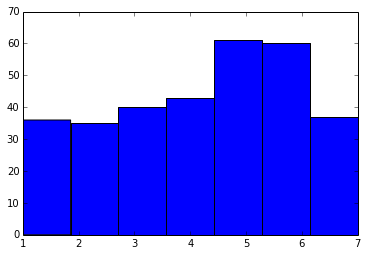

In [5]:
_=plt.hist(week_days[::10000],bins=7)

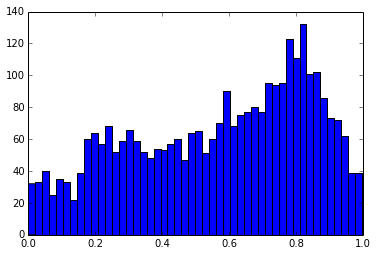

In [6]:
_=plt.hist(rel_times[::1000],bins = 48)

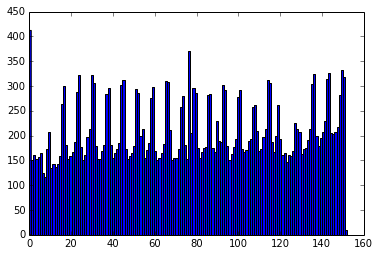

In [7]:
_= plt.hist(ord_days[::100],bins=150)

In [8]:
abs_time = rel_times + ord_days
sort_by_time = np.argsort(abs_time)

# Split data in chronological order

In [16]:
from sklearn.cross_validation import train_test_split

data_sorted = data.iloc[sort_by_time]
abs_time_sorted = abs_time[sort_by_time]

data_sorted = data_sorted[abs_time_sorted <= 150]
abs_time_sorted = abs_time_sorted[abs_time_sorted<=150]


train = data_sorted.iloc[abs_time_sorted<90] #handout for participants
evaluation = data_sorted.iloc[abs_time_sorted>=90] #public and private test

#holdoff for shotgun AND final test


holdoff , test = train_test_split(evaluation,test_size=0.49,random_state=32) #final test to be split into public/private

In [17]:
print len(train),len(holdoff),len(test)

1793300 657387 631609


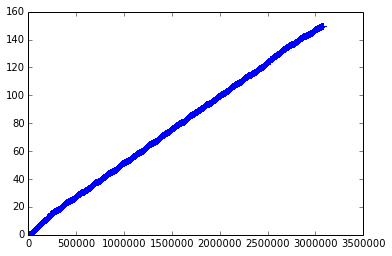

In [18]:
plt.plot(abs_time_sorted,marker='+')

# Add weights

In [33]:
def add_weights(data):
    data = pd.DataFrame.copy(data)
    posclass_prob = data.burned.mean()

    weights = np.ones(len(data))
    weights[data.burned.values] = ((1.-posclass_prob)/posclass_prob)**0.5
    weights[~data.burned.values] =( posclass_prob/(1.-posclass_prob))**.5
    
    data["weights"] = weights
    return data

In [34]:
train,holdoff,test = map(add_weights, [train,holdoff,test])

In [35]:
train.weights[train.burned].sum(),train.weights[~train.burned].sum()

(662980.56421813753, 662980.56421813823)

In [36]:
stats = [
    ('train',train.weights.sum(), len(train), train.weights.max(),train.weights.min(),train.weights.mean()),
    ('holdoff',holdoff.weights.sum(), len(holdoff), holdoff.weights.max(),holdoff.weights.min(),holdoff.weights.mean()),
    ('test',test.weights.sum(), len(test), test.weights.max(),test.weights.min(),test.weights.mean())
    ] 
for tpl in stats:
    print "%s  : \t wsum = %.2f \t len = %i \t w_pos = %.3f \t w_neg = %.3f \t w_mean = %.3f "%(tpl)

train  : 	 wsum = 1325961.13 	 len = 1793300 	 w_pos = 2.263 	 w_neg = 0.442 	 w_mean = 0.739 
holdoff  : 	 wsum = 473756.32 	 len = 657387 	 w_pos = 2.350 	 w_neg = 0.426 	 w_mean = 0.721 
test  : 	 wsum = 455348.78 	 len = 631609 	 w_pos = 2.348 	 w_neg = 0.426 	 w_mean = 0.721 


# Compose data files

In [37]:
train["source"] = "training"
holdoff["source"] = "holdoff"
test["source"] = "testing"

In [38]:
#student handout of test dataset
evaluation = pd.concat([holdoff,test])

evaluation_handout = pd.DataFrame.copy(evaluation)

del evaluation_handout["weights"]
del evaluation_handout["driver_found"]
del evaluation_handout["cancel_time"]
del evaluation_handout["burned"]

In [39]:
evaluation_answers = evaluation[["burned","source","weights"]]

In [40]:
print evaluation.columns
print evaluation_handout.columns

Index([u'cancel_time', u'dist', u'driver_found', u'due', u'f_class', u'lat',
       u'lon', u's_class', u't_class', u'burned', u'weights', u'source'],
      dtype='object')
Index([u'dist', u'due', u'f_class', u'lat', u'lon', u's_class', u't_class',
       u'source'],
      dtype='object')


In [41]:
train.to_csv("train.csv")
holdoff.to_csv("holdoff.csv")
test.to_csv("test.csv")
evaluation.to_csv("evaluation.private.csv")

evaluation_handout.to_csv("evaluation.handout.csv")

In [42]:
evaluation_answers.to_csv("evaluation.answers.csv")